Iván Aguilar - Juan Picciotti

# Detecting Sign Language - YOLOv5

In [17]:
import cv2 as cv
import os
import time
import shutil
from IPython.display import clear_output
import torch
from IPython.display import Image  # for displaying images

import random

from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir


In [32]:
images_path = "/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset"

## Generating the custom dataset

### 1. Generate the Pictures

We define labels and how many pictures we want to generate:

In [19]:
labels = ["hello", "thumb_up"]
number_of_images = 50

The following code opens your webcam and takes frames off of it every 1.5 seconds. During the process it reminds you what label you are taking pictures for, what number of image you are in, and shows the last image captured.

In [19]:
for label in labels:

    # 1. Initiate webcam
    cap = cv.VideoCapture(0)
    print("Images for {} ...".format(label))
    time.sleep(1)
    print("3...")
    time.sleep(1)
    print("2...")
    time.sleep(1)
    print("1...")
    time.sleep(1.5)

    for num in range(number_of_images):
        print("image #{}".format(num))
        # Capture frame by frame:
        ret, frame = cap.read()        
        
        # If frame is read correctly ret is True
        if ret is False:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        if num < 10:
            image_name = images_path + "/" + label + "0" + str(num) + ".jpg"
        else:
            image_name = images_path + "/" + label + str(num) + ".jpg"
            
        # Save image:
        cv.imwrite(image_name, frame)
        
        # Show image:
        plt.imshow(mpimg.imread(image_name))
        plt.draw()
        plt.pause(0.1) # pause how many seconds
        print("change pose")
        print("2..")
        time.sleep(1)
        print("1..")
        time.sleep(1.5)
        clear_output()
        
        
    cap.release()

    
print("Finished ...")

Finished ...


### 2. Label the images you just generated:

We employ the app 'labelImg' which can be found in https://github.com/tzutalin/labelImg


In [ ]:
#!pip install pyqt5 lxml 
!python /Users/juanpicciotti/BSE/2term/CML_II/project/Labeling/labelImg.py

### 3. Check the results

In [21]:
%cd /Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset/

/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset


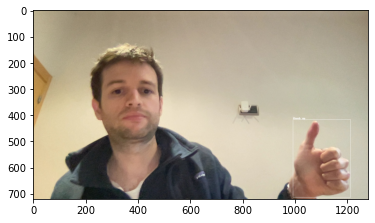

In [50]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"hello": 15,
                           "thumb_up": 16}


class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

annotations = [f for f in listdir(images_path) if f[-3:] == "txt"]

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


In the process of labeling, we made a mistake and defined our 2 labels "Hello" and "Thumb_up!" with id 15 and 16. In order to correct that, we use this code, which opens each .txt and replaces 15 and 16 with 0 and 1.

In [45]:
# Reformating some label files:

%cd "/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset"

# Opening our text file in read only
# mode using the open() function
for elem in ["hello", "thumb_up"]:
    
    if elem == "hello":
        x = "0 "
    else: 
        x = "1 "
    
    for i in range(50):
        if i < 10:

            with open(r'{}0{}.txt'.format(elem, i), 'r') as file:

                # Reading the content of the file
                # using the read() function and storing
                # them in a new variable
                data = file.read()

                # Searching and replacing the text
                # using the replace() function
                data = x + data[2:]

            # Opening our text file in write only
            # mode to write the replaced content
            with open(r'{}0{}.txt'.format(elem, i), 'w') as file:

                # Writing the replaced data in our
                # text file
                file.write(data)
        else:

            with open(r'{}{}.txt'.format(elem, i), 'r') as file:

                # Reading the content of the file
                # using the read() function and storing
                # them in a new variable
                data = file.read()

                # Searching and replacing the text
                # using the replace() function
                data = x + data[2:]

            # Opening our text file in write only
            # mode to write the replaced content
            with open(r'{}{}.txt'.format(elem, i), 'w') as file:

                # Writing the replaced data in our
                # text file
                file.write(data)


/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset


### Train-test-validation split

We have 100 custom images:
- 50 of us signaling "hello".
- 50 giving "thumb up".

In order to train, validate and test the model, we split those into:
- 80% for training purposes.
- 10% for validating purposes.
- 10% for testing purposes.

And move them to new folders as YOLOv5 requires.

In [52]:
!pwd

/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset


In [54]:
# Read images and annotations
images = [f for f in listdir(images_path) if f[-3:] == "jpg"]
annotations = [f for f in listdir(images_path) if f[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

# Create new folders for training, testing and validation sets:
#!mkdir images/train images/val images/test labels/train labels/val labels/test



# Move the splits into their folders

def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

            
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')


In [57]:
%cd ../yolov5

/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/yolov5


# Training YOLO with the Custom Dataset we just made

Training:

In [165]:
!python train.py --img 320 --cfg yolov5_2classes.yaml --hyp hyp.scratch-med.yaml --batch 32 --epochs 150 --data ourselves.yaml --weights yolov5s.pt --workers 24 --name ourselves

train: weights=yolov5s.pt, cfg=yolov5_2classes.yaml, data=ourselves.yaml, hyp=hyp.scratch-med.yaml, epochs=150, batch_size=32, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=ourselves, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9 (delta 4), reused 9 (delta 4), pack-reused 0
Unpacking objects: 100% (9/9), 2.33 KiB | 159.00 KiB/s, done.
From https://github.com/ultralytics/yolov5
   c9778a4..70a32f1  test/conv_reduction -> origin/test/conv_reduction
github: ⚠️ YOLOv5 is out of date by 15 commits. U

Predicting:

In [166]:
!python detect.py --source ../custom_dataset/test/images/ --weights runs/train/ourselves5/weights/best.pt --conf 0.5 --name yolo_ourselves_det

detect: weights=['runs/train/ourselves5/weights/best.pt'], source=../custom_dataset/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_ourselves_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-21-ge6e36aa torch 1.10.2 CPU

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/10 /Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset/test/images/hello31.jpg: 384x640 1 Hello!, Done. (0.089s)
image 2/10 /Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset/test/images/hello33.jpg: 384x640 1 Hello!, Done. (0.084s)
image 3/10 /Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/custom_dataset/test/images/hello36.jpg: 3

Checking:

/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/yolov5/runs/detect/yolo_ourselves_det/hello33.jpg


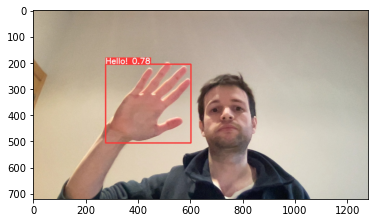

In [188]:
detections_dir = "/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/yolov5/runs/detect/yolo_ourselves_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_image = random.choice(detection_images)
print(random_image)

random_detection_image = Image.open(random_image)
plt.imshow(np.array(random_detection_image))

# roboflow dataset

Training the model on colab is much faster. We ran it once and took 7.5 hrs:

In [190]:
#!python train.py --img 320 --cfg yolov5_26classes.yaml --hyp hyp.scratch-med.yaml --batch 32 --epochs 150 --data roboflow_data.yaml --weights yolov5s.pt --workers 24 --name roboflow_asl

train: weights=yolov5s.pt, cfg=yolov5_26classes.yaml, data=roboflow_data.yaml, hyp=hyp.scratch-med.yaml, epochs=150, batch_size=32, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=roboflow_asl, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 393 bytes | 49.00 KiB/s, done.
From https://github.com/ultralytics/yolov5
   df06e00..84651d8  test/conv_reduction -> origin/test/conv_reduction
github: ⚠️ YOLOv5 is out of date by 15 commits. Use `git pull` or `git clone https://git

In [61]:
!pwd

/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/yolov5


In [192]:
# this employs the weights we got by training in colab
!python detect.py --source ../roboflow_ASL/test/images/ --weights runs/train/roboflow_asl4/weights/best.pt --conf 0.1 --name yolo_roboflow_det

detect: weights=['runs/train/roboflow_asl4/weights/best.pt'], source=../roboflow_ASL/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_roboflow_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-21-ge6e36aa torch 1.10.2 CPU

Fusing layers... 
Model Summary: 213 layers, 7080247 parameters, 0 gradients, 16.0 GFLOPs
image 1/72 /Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/roboflow_ASL/test/images/A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg: 640x640 1 A, Done. (0.148s)
image 2/72 /Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/roboflow_ASL/test/images/B14_jpg.rf.ed5ba6d44f55ab03e62d2baeac4aa1aa.jpg: 640x640 1 B, Done. (0.139s)
image 3/72 /Users/juanpicciotti/BSE/2term/CML

/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/yolov5/runs/detect/yolo_roboflow_det/Z18_jpg.rf.2cffbd9beaeb50a7d03751c3ce738e81.jpg


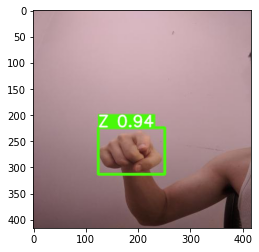

In [195]:
detections_dir = "/Users/juanpicciotti/BSE/2term/CML_II/project/YOLO/yolov5/runs/detect/yolo_roboflow_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_image = random.choice(detection_images)
print(random_image)

random_detection_image = Image.open(random_image)
plt.imshow(np.array(random_detection_image))

